# Simulated DCA Demo

In [1]:
from hyppo.tools import SIMULATIONS
from matplotlib import cm
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA

import dist_cov as dc

In [2]:
np.random.seed(4)

# 1D Simulated Linear Independence Data
## Plot Dataset

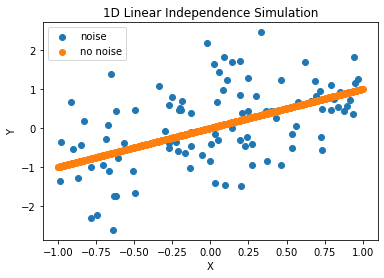

In [3]:
lin_sim = SIMULATIONS["linear"]
lin_x_n, lin_y_n = lin_sim(100, 1, noise=True)
lin_x, lin_y = lin_sim(1000, 1)
plt.scatter(lin_x_n, lin_y_n)
plt.scatter(lin_x, lin_y)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("1D Linear Independence Simulation")
plt.legend(["noise", "no noise"]);

## Initialize Data

In [4]:
X, Y = lin_sim(10, 1, noise=True)
D_X = dc.dist_mat(X)
D_Y = dc.dist_mat(Y)
R_X = dc.re_centered_dist(D_X)
R_Y = dc.re_centered_dist(D_Y)
u = np.random.rand(X.shape[1], 1)
u = dc.clamp_u(u)
u_norm = LA.norm(u)
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
print(f"u: {u}")
print(f"u norm: {u_norm}")
R_X_u = dc.re_centered_dist_u(u, X)

X shape: (10, 1)
Y shape: (10, 1)
u: [[0.01399029]]
u norm: 0.013990288803688022


## Test Function Dimension Alignment

In [5]:
du = dc.dist_cov_sq_grad(u, X, R_Y)
print(f"dvdu: {du}")
v = dc.dist_cov_sq(R_X, R_Y)
print(f"v^2: {v}")

dvdu: [0.10216473]
v^2: 0.10216472924060427


## Optimize $u$

In [6]:
v_u = dc.dist_cov_sq(R_Y, R_X_u)
print(f"v^2_u: {v_u}")
u_opt = dc.optim_u_gd(u, X, R_Y, 1e-1, 1e-3)
print(f"u opt: {u_opt}")
R_X_u_opt = dc.re_centered_dist_u(u_opt, X)
v_u_opt = dc.dist_cov_sq(R_Y, R_X_u_opt)
print(f"v^2_u_opt: {v_u_opt}")

v^2_u: 0.001429314067626644
u opt: [[1.]]
v^2_u_opt: 0.10216472924060427


## Plot Gradient Ascent

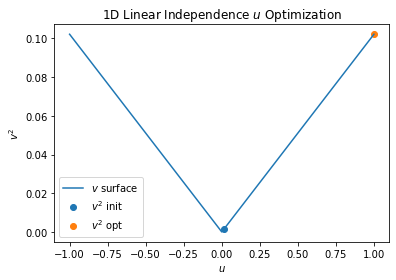

In [7]:
u_plt = np.expand_dims(np.linspace(-1, 1, 11), 1)
v_u_plt = np.zeros_like(u_plt)
for i in range(u_plt.shape[0]):
    R_X_u_i = dc.re_centered_dist_u(u_plt[i], X)
    v_u_i = dc.dist_cov_sq(R_Y, R_X_u_i)
    v_u_plt[i] = v_u_i
plt.plot(u_plt, v_u_plt)
plt.scatter([u], [v_u])
plt.scatter([u_opt], [v_u_opt])
plt.xlabel(r"$u$")
plt.ylabel(r"$v^2$")
plt.title(r"1D Linear Independence $u$ Optimization")
plt.legend([r'$v$ surface', r'$v^2$ init', r'$v^2$ opt']);

# 2D Simulated Linear Independence Data
## Plot Dataset

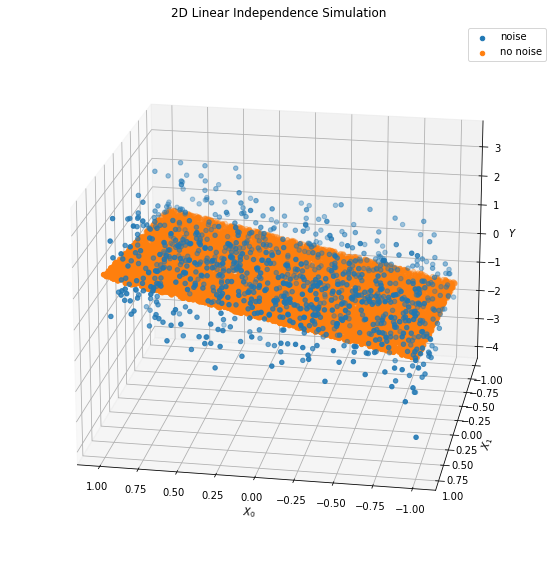

In [8]:
lin_sim = SIMULATIONS["linear"]
lin_x_n, lin_y_n = lin_sim(1000, 2, noise=True)
lin_x, lin_y = lin_sim(10000, 2)

lin_x_1_n = lin_x_n[:, 0]
lin_x_2_n = lin_x_n[:, 1]
lin_x_1 = lin_x[:, 0]
lin_x_2 = lin_x[:, 1]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(lin_x_1_n, lin_x_2_n, lin_y_n)
ax.scatter(lin_x_1, lin_x_2, lin_y)
ax.set_xlabel(r"$X_0$")
ax.set_ylabel(r"$X_1$")
ax.set_zlabel(r"$Y$")
plt.title("2D Linear Independence Simulation")
plt.legend(["noise", "no noise"])
ax.view_init(elev=20, azim=100);

## Initialize Data

In [9]:
X, Y = lin_sim(10, 2, noise=True)
D_X = dc.dist_mat(X)
D_Y = dc.dist_mat(Y)
R_X = dc.re_centered_dist(D_X)
R_Y = dc.re_centered_dist(D_Y)
u = np.random.rand(X.shape[1])
u = dc.clamp_u(u)
u_norm = LA.norm(u)
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
print(f"u: {u}")
print(f"u norm: {u_norm}")
R_X_u = dc.re_centered_dist_u(u, X)

X shape: (10, 2)
Y shape: (10, 1)
u: [0.3953467  0.64467766]
u norm: 0.7562461908499388


## Test Function Dimension Alignment

In [10]:
du = dc.dist_cov_sq_grad(u, X, R_Y)
print(f"dvdu: {du}")
v = dc.dist_cov_sq(R_X, R_Y)
print(f"v^2: {v}")

dvdu: [0.29720569 0.04504573]
v^2: 0.24953504621553899


## Optimize $u$

In [11]:
v_u = dc.dist_cov_sq(R_Y, R_X_u)
print(f"v^2_u: {v_u}")
u_opt = dc.optim_u_gd(u, X, R_Y, 1e-1, 1e-5)
print(f"u opt: {u_opt}")
R_X_u_opt = dc.re_centered_dist_u(u_opt, X)
v_u_opt = dc.dist_cov_sq(R_Y, R_X_u_opt)
print(f"v^2_u_opt: {v_u_opt}")

v^2_u: 0.14653926438302453
u opt: [0.87641816 0.48155083]
v^2_u_opt: 0.29228062966392854


## Plot Gradient Ascent

In [12]:
surf_res = 1e-1
X_surf = np.arange(-1, 1, surf_res)
Y_surf = np.arange(-1, 1, surf_res)
X_surf, Y_surf = np.meshgrid(X_surf, Y_surf)
v_u_plt = np.zeros_like(X_surf)
for i in range(X_surf.shape[0]):
    for j in range(X_surf.shape[1]):
        R_X_u_i = dc.re_centered_dist_u(np.array([X_surf[i, j], Y_surf[i, j]]), X)
        v_u_i = dc.dist_cov_sq(R_Y, R_X_u_i)
        v_u_plt[i, j] = v_u_i

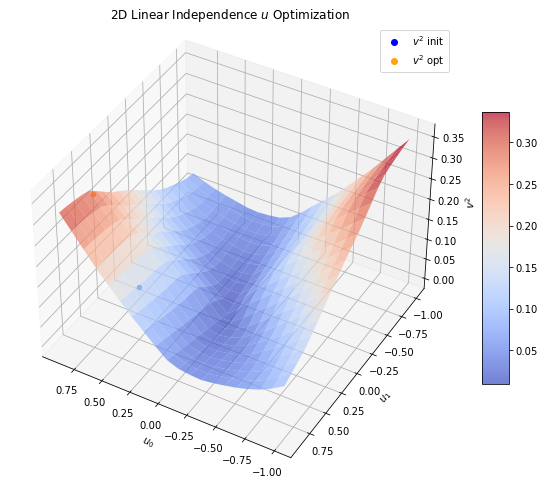

In [13]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
surf = ax.plot_surface(X_surf, Y_surf, v_u_plt, cmap=cm.coolwarm, linewidth=0, antialiased=True, alpha=.7)
ax.scatter([u[0]], [u[1]], [v_u])
ax.scatter([u_opt[0]], [u_opt[1]], [v_u_opt])
ax.set_xlabel(r"$u_0$")
ax.set_ylabel(r"$u_1$")
ax.set_zlabel(r"$v^2$")
ax.set_title(r"2D Linear Independence $u$ Optimization")
init_proxy = Line2D([0], [0], linestyle="none", c='blue', marker='o')
opt_proxy = Line2D([0], [0], linestyle="none", c='orange', marker='o')
ax.legend([init_proxy, opt_proxy], [r'$v^2$ init', r'$v^2$ opt'], numpoints=1)
fig.colorbar(surf, shrink=0.5, aspect=10)
ax.view_init(elev=40, azim=120);

# nD Simulated Linear Independence Data
## Initialize Data

In [14]:
lin_sim = SIMULATIONS["linear"]
X, Y = lin_sim(100, 10, noise=True)
D_X = dc.dist_mat(X)
D_Y = dc.dist_mat(Y)
R_X = dc.re_centered_dist(D_X)
R_Y = dc.re_centered_dist(D_Y)
u = np.random.rand(X.shape[1])
u = dc.clamp_u(u)
u_norm = LA.norm(u)
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
print(f"u: {u}")
print(f"u norm: {u_norm}")
R_X_u = dc.re_centered_dist_u(u, X)

X shape: (100, 10)
Y shape: (100, 1)
u: [0.39430583 0.07493599 0.19800481 0.35994727 0.34665606 0.18917369
 0.43687918 0.40338308 0.19501519 0.35010029]
u norm: 0.9999999999999999


## Test Function Dimension Alignment

In [15]:
du = dc.dist_cov_sq_grad(u, X, R_Y)
print(f"dvdu: {du}")
v = dc.dist_cov_sq(R_X, R_Y)
print(f"v^2: {v}")

dvdu: [ 0.08079626  0.00459028  0.02995579  0.01787511  0.00318059  0.04523502
  0.0276689  -0.00458484  0.04459729 -0.00850977]
v^2: 0.0592567689385496


## Optimize $u$

In [16]:
v_u = dc.dist_cov_sq(R_Y, R_X_u)
print(f"v^2_u: {v_u}")
u_opt = dc.optim_u_gd(u, X, R_Y, 1e-1, 1e-3)
print(f"u opt: {u_opt}")
R_X_u_opt = dc.re_centered_dist_u(u_opt, X)
v_u_opt = dc.dist_cov_sq(R_Y, R_X_u_opt)
print(f"v^2_u_opt: {v_u_opt}")

v^2_u: 0.07018413940676281
u opt: [0.39956577 0.0748667  0.1995919  0.35919996 0.34454273 0.19233987
 0.43656529 0.40010113 0.19807712 0.34680197]
v^2_u_opt: 0.07094908435020574
